# TP1 : Probabilité

In [1]:
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt

from functools import reduce
from typing import Callable

## 1. Récupération des données

In [2]:
def get_dataframe_from_csv(*args: str) -> tuple[pd.DataFrame]:
    dataframes = []
    for file_name in args:
        df = pd.read_csv(f'csv/{file_name}.csv')
        dataframes.append(df)
    return tuple(dataframes)

In [3]:
datas_frames = get_dataframe_from_csv('DJI', 'FCHI', 'FTSE', 'GDAXI', 'IXIC')
DJI, FCHI, FTSE, GDAXI, IXIC = datas_frames

In [4]:
tuple(map(lambda df: len(df), datas_frames))

(250, 257, 250, 257, 250)

## 2. Traitement de la colonne "Adj Close"

In [5]:
def merge_adj_datas_frames(**kwargs: pd.DataFrame) -> pd.DataFrame:
    dfs_date_ajd: list[pd.DataFrame] = []
    for key, df in kwargs.items():
        dfac = df[["Date", "Adj Close"]]
        dfac= dfac.rename(columns={"Adj Close": f"{key} Adj Close"})
        dfs_date_ajd.append(dfac)
    
    return reduce(lambda left, right: pd.merge(left, right, how='outer'), dfs_date_ajd)

In [6]:
df_adj_close = merge_adj_datas_frames(DJI=DJI, FCHI=FCHI, FTSE=FTSE, GDAXI=GDAXI, IXIC=IXIC)
df_adj_close

,Date,DJI Adj Close,FCHI Adj Close,FTSE Adj Close,GDAXI Adj Close,IXIC Adj Close
0,2022-01-10,36068.871094,7115.770020,7445.299805,15768.269531,14942.830078
1,2022-01-11,36252.019531,7183.379883,7491.399902,15941.809570,15153.450195
2,2022-01-12,36290.320313,7237.189941,7551.700195,16010.320313,15188.389648
3,2022-01-13,36113.621094,7201.140137,7563.899902,16031.589844,14806.809570
4,2022-01-14,35911.808594,7143.000000,7543.000000,15883.240234,14893.750000
...,...,...,...,...,...,...
253,2022-06-20,NaN,5920.089844,7121.799805,13265.599609,NaN
254,2022-07-04,NaN,5954.649902,7232.700195,12773.379883,NaN
255,2022-09-05,NaN,6093.220215,7287.399902,12760.780273,NaN
256,2022-11-24,NaN,6707.319824,7466.600098,14539.559570,NaN


In [7]:
def fill_adj_close(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    columns = df.loc[:, df_adj_close.columns != 'Date']
    for column in columns:
        for i in range(len(df)):
            if math.isnan(df.loc[i, column]):
                df.loc[i, column] = df.loc[i - 1, column]
    return df


In [8]:
df_adj_close = fill_adj_close(df_adj_close)
df_adj_close


,Date,DJI Adj Close,FCHI Adj Close,FTSE Adj Close,GDAXI Adj Close,IXIC Adj Close
0,2022-01-10,36068.871094,7115.770020,7445.299805,15768.269531,14942.830078
1,2022-01-11,36252.019531,7183.379883,7491.399902,15941.809570,15153.450195
2,2022-01-12,36290.320313,7237.189941,7551.700195,16010.320313,15188.389648
3,2022-01-13,36113.621094,7201.140137,7563.899902,16031.589844,14806.809570
4,2022-01-14,35911.808594,7143.000000,7543.000000,15883.240234,14893.750000
...,...,...,...,...,...,...
253,2022-06-20,33630.609375,5920.089844,7121.799805,13265.599609,10569.290039
254,2022-07-04,33630.609375,5954.649902,7232.700195,12773.379883,10569.290039
255,2022-09-05,33630.609375,6093.220215,7287.399902,12760.780273,10569.290039
256,2022-11-24,33630.609375,6707.319824,7466.600098,14539.559570,10569.290039


## 3. Définition d'un série discrète sur la base de chacune  des séries obtenues.

In [9]:
def create_series(series: pd.Series) -> list[float]:
    array: list[float] = []
    for i, value in enumerate(series):
        if (i == 0):
            array.append(0)
        else:
            ln = math.log(value/series[i - 1])
            if (ln > 0.005):
                array.append(1)
            elif (ln < -0.005):
                array.append(-1)
            else:
                array.append(0)
    return array

def toSerie(df: pd.DataFrame):
    dict_serie = {'Date': df['Date']}
    for column in df.loc[:, df_adj_close.columns != 'Date']:
        dict_serie[column] = create_series(df[column])
    return pd.DataFrame.from_dict(dict_serie)
    


In [10]:
df_adj_close_serie = toSerie(df_adj_close)
df_adj_close_serie

,Date,DJI Adj Close,FCHI Adj Close,FTSE Adj Close,GDAXI Adj Close,IXIC Adj Close
0,2022-01-10,0,0,0,0,0
1,2022-01-11,1,1,1,1,1
2,2022-01-12,0,1,1,0,0
3,2022-01-13,0,0,0,0,-1
4,2022-01-14,-1,-1,0,-1,1
...,...,...,...,...,...,...
253,2022-06-20,0,-1,-1,-1,0
254,2022-07-04,0,1,1,-1,0
255,2022-09-05,0,1,1,0,0
256,2022-11-24,0,1,1,1,0


## 4. Création de la table des probabilités des St

In [11]:
def get_prob(df: pd.DataFrame):
    indexs = []
    dictionary = {
        'P(-1)': [],
        'P(0)': [],
        'P(1)': [],
    }
    for column in df.loc[:, df.columns != 'Date']:
        serie = df[column]
        total = len(serie)
        indexs.append(column.split(' ')[0])
        dictionary['P(-1)'].append(len(df[serie == -1])/total)
        dictionary['P(0)'].append(len(df[serie == 0])/total)
        dictionary['P(1)'].append(len(df[serie == 1])/total)
    return pd.DataFrame(dictionary, index=indexs)

df_prob = get_prob(df_adj_close_serie)
df_prob

,P(-1),P(0),P(1)
DJI,0.310078,0.387597,0.302326
FCHI,0.341085,0.337209,0.321705
FTSE,0.232558,0.484496,0.282946
GDAXI,0.348837,0.294574,0.356589
IXIC,0.430233,0.224806,0.344961


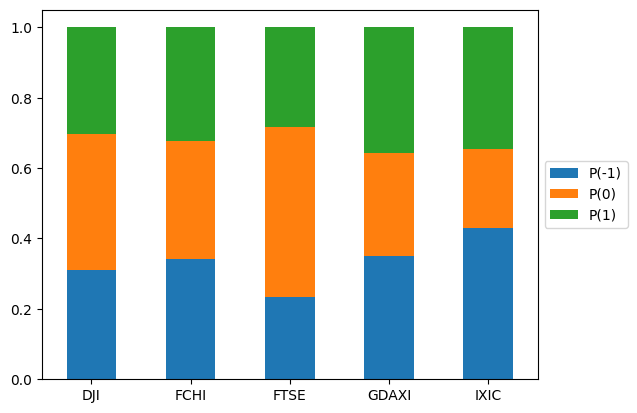

In [12]:
df_prob.plot(kind='bar', rot=0, stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## 5. Calcule des indices
### Indices de Pr(st, st+1),

In [13]:
def st_prob_couple(series: pd.Series):
    couples_count = {}
    for i, value in enumerate(series):
        if i == len(series) - 1: continue
        key = f"P({value}, {series[i + 1]})"
        if key in couples_count:
            couples_count[key] = couples_count.get(key) + 1
        else:
            couples_count[key] = 1
    
    for key in couples_count:
        couples_count[key] = [couples_count[key] / len(series)]
    df = pd.DataFrame(couples_count, index=[series.name.split(' ')[0]])
    return df.reindex(sorted(df.columns), axis=1)


df_st_prob_couple = pd.concat([st_prob_couple(df_adj_close_serie[column]) for column in df_adj_close_serie.loc[:, df_adj_close_serie.columns != 'Date']])
df_st_prob_couple

,"P(-1, -1)","P(-1, 0)","P(-1, 1)","P(0, -1)","P(0, 0)","P(0, 1)","P(1, -1)","P(1, 0)","P(1, 1)"
DJI,0.112403,0.127907,0.069767,0.104651,0.135659,0.143411,0.093023,0.120155,0.089147
FCHI,0.127907,0.096899,0.112403,0.093023,0.135659,0.108527,0.120155,0.100775,0.100775
FTSE,0.065891,0.100775,0.065891,0.104651,0.251938,0.124031,0.062016,0.127907,0.093023
GDAXI,0.143411,0.085271,0.116279,0.077519,0.104651,0.112403,0.127907,0.100775,0.127907
IXIC,0.193798,0.089147,0.147287,0.077519,0.058140,0.085271,0.158915,0.073643,0.112403


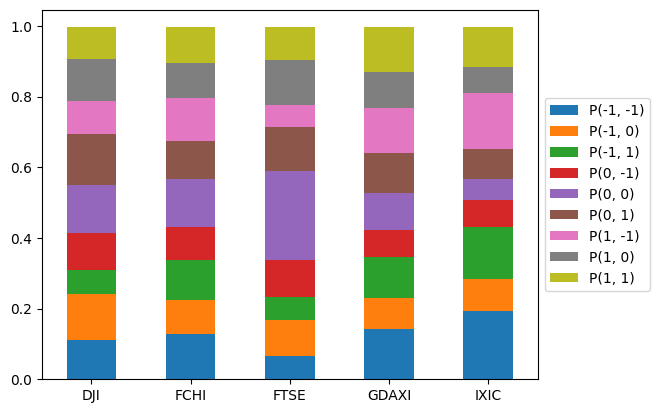

In [14]:
df_st_prob_couple.plot(kind='bar', rot=0, stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


### Indices de Pr(st | st−1)

In [15]:
def st_prob_current_previous(series: pd.Series):
    indices = [-1, 0, 1]
    dictionnary = {}
    for i_indice in indices:
        for j_indice in indices:
            total = 0
            label = f'P({i_indice}|{j_indice})'
            for index, serie in enumerate(series):
                if index == 0: continue
                if serie == i_indice: total+=1
                if serie == i_indice and series[index - 1] == j_indice:
                    if label in dictionnary:
                        dictionnary[label] += 1
                    else:
                        dictionnary[label] = 1
            dictionnary[label] = [dictionnary[label]/total]
    
    df = pd.DataFrame(dictionnary, index=[series.name.split(' ')[0]])
    return df.reindex(sorted(df.columns), axis=1)


df_st_prob_cur_prev = pd.concat([st_prob_current_previous(df_adj_close_serie[column]) for column in df_adj_close_serie.loc[:, df_adj_close_serie.columns != 'Date']])
df_st_prob_cur_prev

,P(-1|-1),P(-1|0),P(-1|1),P(0|-1),P(0|0),P(0|1),P(1|-1),P(1|0),P(1|1)
DJI,0.362500,0.337500,0.300000,0.333333,0.353535,0.313131,0.230769,0.474359,0.294872
FCHI,0.375000,0.272727,0.352273,0.290698,0.406977,0.302326,0.349398,0.337349,0.313253
FTSE,0.283333,0.450000,0.266667,0.209677,0.524194,0.266129,0.232877,0.438356,0.328767
GDAXI,0.411111,0.222222,0.366667,0.293333,0.360000,0.346667,0.326087,0.315217,0.358696
IXIC,0.450450,0.180180,0.369369,0.403509,0.263158,0.333333,0.426966,0.247191,0.325843


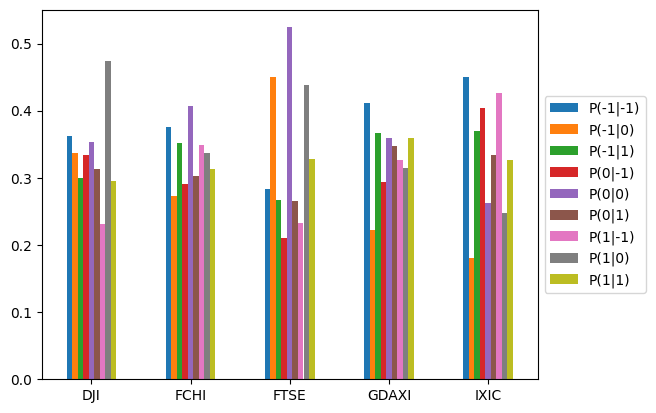

In [16]:
df_st_prob_cur_prev.plot(kind='bar', rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Indices de Pr(st | st+1)

In [17]:
def st_prob_current_next(series: pd.Series):
    indices = [-1, 0, 1]
    dictionnary = {}
    for i_indice in indices:
        for j_indice in indices:
            total = 0
            label = f'P({i_indice}|{j_indice})'
            for index, serie in enumerate(series):
                if index == len(series) - 1: continue
                if serie == i_indice: total += 1
                if serie == i_indice and series[index + 1] == j_indice:
                    if label in dictionnary:
                        dictionnary[label] += 1
                    else:
                        dictionnary[label] = 1
            dictionnary[label] = [dictionnary[label]/total]

    df = pd.DataFrame(dictionnary, index=[series.name.split(' ')[0]])
    return df.reindex(sorted(df.columns), axis=1)


df_st_prob_cur_next = pd.concat([st_prob_current_next(df_adj_close_serie[column]) for column in df_adj_close_serie.loc[:, df_adj_close_serie.columns != 'Date']])
df_st_prob_cur_next


,P(-1|-1),P(-1|0),P(-1|1),P(0|-1),P(0|0),P(0|1),P(1|-1),P(1|0),P(1|1)
DJI,0.362500,0.412500,0.225000,0.272727,0.353535,0.373737,0.307692,0.397436,0.294872
FCHI,0.379310,0.287356,0.333333,0.275862,0.402299,0.321839,0.373494,0.313253,0.313253
FTSE,0.283333,0.433333,0.283333,0.217742,0.524194,0.258065,0.219178,0.452055,0.328767
GDAXI,0.415730,0.247191,0.337079,0.263158,0.355263,0.381579,0.358696,0.282609,0.358696
IXIC,0.450450,0.207207,0.342342,0.350877,0.263158,0.385965,0.460674,0.213483,0.325843


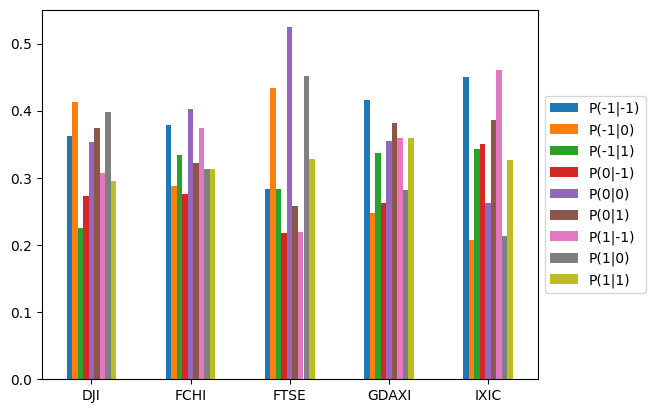

In [18]:
df_st_prob_cur_next.plot(kind='bar', rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


## 6. Calcul des couples d'indices

In [19]:
columns = df_adj_close_serie.loc[:, df_adj_close_serie.columns != 'Date']

def create_df_concat(df, columns, fn: Callable[[pd.Series, pd.Series], pd.DataFrame]):
    dfs_list = []
    for i_column in columns:
        for j_columns in columns:
            if i_column == j_columns: continue
            dfs_list.append(fn(df[i_column], df[j_columns]))
    return pd.concat(dfs_list)


### Indices de Pr(st(i), st(j))

In [20]:
def st_prob_datas_couple(series_1: pd.Series, series_2: pd.Series):
    name_1 = series_1.name.split(' ')[0]
    name_2 = series_2.name.split(' ')[0]
    dictionnary = {}
    zip_list = list(zip(series_1.to_list(), series_2.to_list()))
    
    for value_1, value_2 in zip_list:
        label = f'P({value_1}, {value_2})'
        if label in dictionnary:
            dictionnary[label]+=1
        else:
            dictionnary[label] = 1
    
    for key in dictionnary:
        dictionnary[key] = dictionnary[key]/len(zip_list)
    
    df = pd.DataFrame(dictionnary, index=[f'{name_1} | {name_2}'])
    return df.reindex(sorted(df.columns), axis=1)

df_st_prob_datas_couple = create_df_concat(df_adj_close_serie, columns, st_prob_datas_couple).fillna(0)
df_st_prob_datas_couple


,"P(-1, -1)","P(-1, 0)","P(-1, 1)","P(0, -1)","P(0, 0)","P(0, 1)","P(1, -1)","P(1, 0)","P(1, 1)"
DJI | FCHI,0.186047,0.081395,0.042636,0.124031,0.158915,0.104651,0.031008,0.096899,0.174419
DJI | FTSE,0.116279,0.155039,0.038760,0.096899,0.189922,0.100775,0.019380,0.139535,0.143411
DJI | GDAXI,0.193798,0.058140,0.058140,0.139535,0.143411,0.104651,0.015504,0.093023,0.193798
DJI | IXIC,0.279070,0.027132,0.003876,0.143411,0.178295,0.065891,0.007752,0.019380,0.275194
FCHI | DJI,0.186047,0.124031,0.031008,0.081395,0.158915,0.096899,0.042636,0.104651,0.174419
FCHI | FTSE,0.178295,0.143411,0.019380,0.046512,0.244186,0.046512,0.007752,0.096899,0.217054
FCHI | GDAXI,0.310078,0.031008,0.000000,0.034884,0.228682,0.073643,0.003876,0.034884,0.282946
FCHI | IXIC,0.213178,0.077519,0.050388,0.131783,0.100775,0.104651,0.085271,0.046512,0.189922
FTSE | DJI,0.116279,0.096899,0.019380,0.155039,0.189922,0.139535,0.038760,0.100775,0.143411
FTSE | FCHI,0.178295,0.046512,0.007752,0.143411,0.244186,0.096899,0.019380,0.046512,0.217054


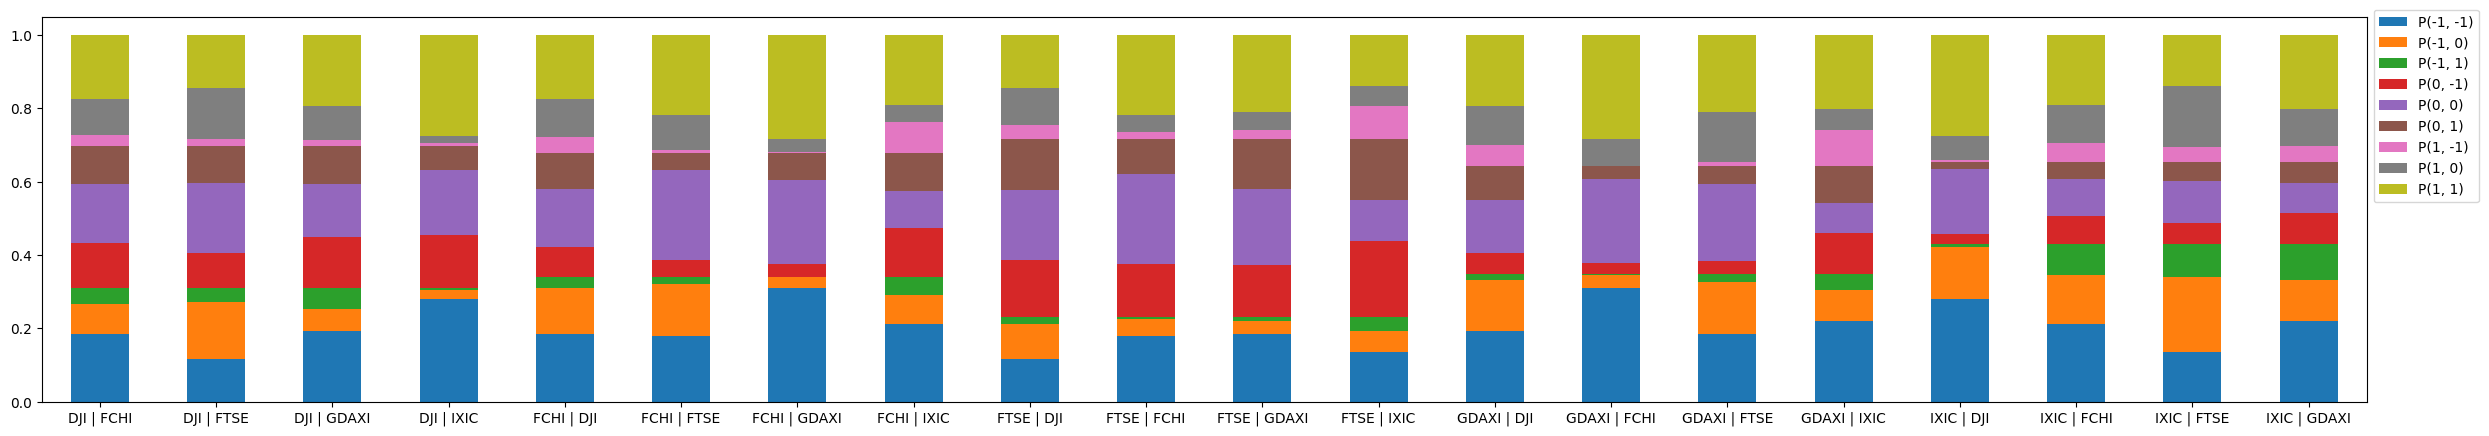

In [21]:
df_st_prob_datas_couple.plot(kind='bar', rot=0, stacked=True, figsize=(30, 5))
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plt.show()


### Indices de Pr(st(i)|st(j))

In [22]:
def st_prob_datas_indices(series_1: pd.Series, series_2: pd.Series):
    name_1 = series_1.name.split(' ')[0]
    name_2 = series_2.name.split(' ')[0]
    indices = [-1, 0, 1]
    dictionnary = {}
    for i_indice in indices:
        for j_indice in indices:
            total = 0
            label = f'P({i_indice}|{j_indice})'
            for index, (value_1, value_2) in enumerate(zip(series_1.to_list(), series_2.to_list())):
                if value_1 == i_indice: total+=1
                if value_1 == i_indice and value_2 == j_indice:
                    if label in dictionnary:
                        dictionnary[label] += 1
                    else:
                        dictionnary[label] = 1
            try:
                dictionnary[label] = [dictionnary[label]/total]
            except KeyError as err:
                dictionnary[label] = [0]
    df = pd.DataFrame(dictionnary, index=[f'{name_1} | {name_2}'])
    return df.reindex(sorted(df.columns), axis=1)
                
df_st_prob_datas_indices = create_df_concat(df_adj_close_serie, columns, st_prob_datas_indices).fillna(0)
df_st_prob_datas_indices

,P(-1|-1),P(-1|0),P(-1|1),P(0|-1),P(0|0),P(0|1),P(1|-1),P(1|0),P(1|1)
DJI | FCHI,0.600000,0.262500,0.137500,0.320000,0.410000,0.270000,0.102564,0.320513,0.576923
DJI | FTSE,0.375000,0.500000,0.125000,0.250000,0.490000,0.260000,0.064103,0.461538,0.474359
DJI | GDAXI,0.625000,0.187500,0.187500,0.360000,0.370000,0.270000,0.051282,0.307692,0.641026
DJI | IXIC,0.900000,0.087500,0.012500,0.370000,0.460000,0.170000,0.025641,0.064103,0.910256
FCHI | DJI,0.545455,0.363636,0.090909,0.241379,0.471264,0.287356,0.132530,0.325301,0.542169
FCHI | FTSE,0.522727,0.420455,0.056818,0.137931,0.724138,0.137931,0.024096,0.301205,0.674699
FCHI | GDAXI,0.909091,0.090909,0.000000,0.103448,0.678161,0.218391,0.012048,0.108434,0.879518
FCHI | IXIC,0.625000,0.227273,0.147727,0.390805,0.298851,0.310345,0.265060,0.144578,0.590361
FTSE | DJI,0.500000,0.416667,0.083333,0.320000,0.392000,0.288000,0.136986,0.356164,0.506849
FTSE | FCHI,0.766667,0.200000,0.033333,0.296000,0.504000,0.200000,0.068493,0.164384,0.767123


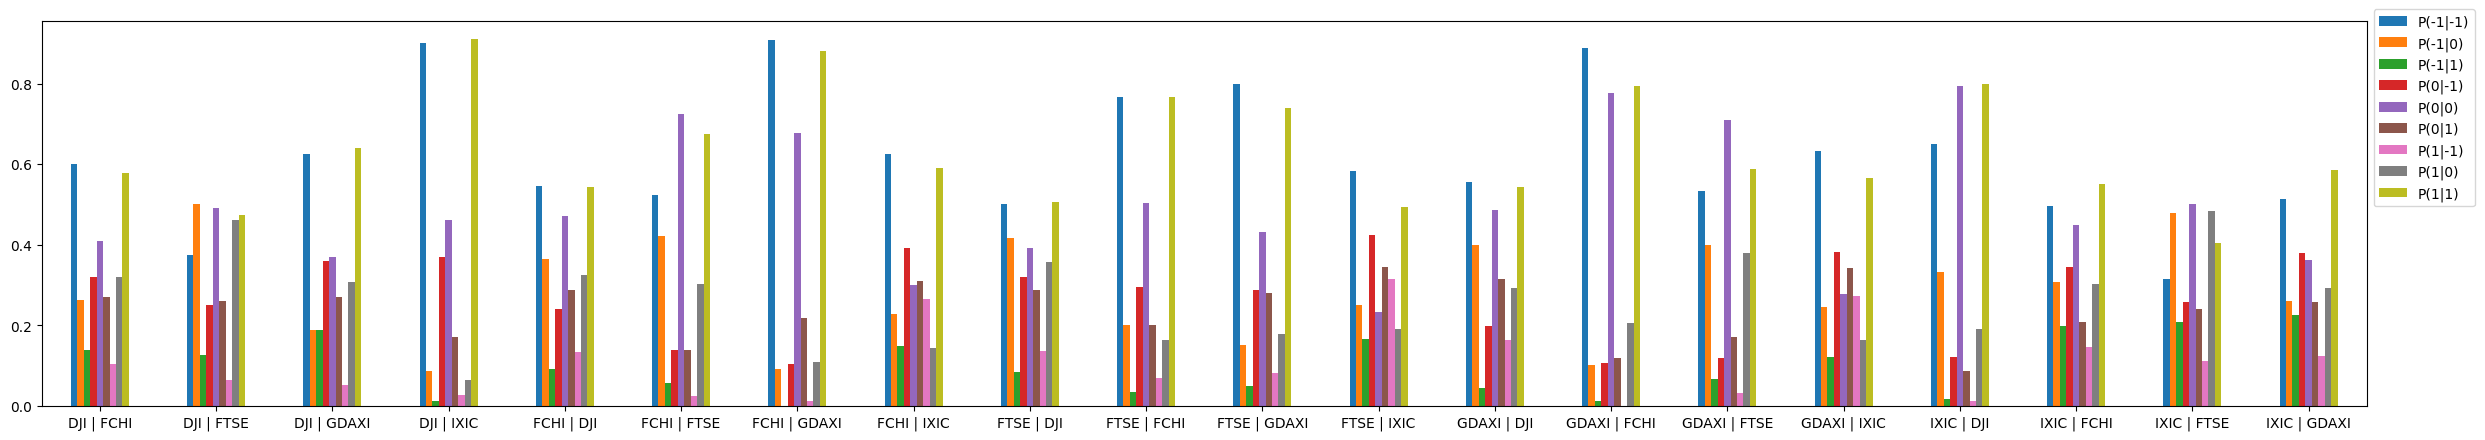

In [23]:
df_st_prob_datas_indices.plot(kind='bar', rot=0, figsize=(30, 5))
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## 7. Calcul des indices S(i)

## 8. Qu’est-ce que vous pouvez déduire en comparant ces probabilités ?
A partir des résultats afficher ci-dessus, nous remarquons de forte de faible probabilités par d'augmentation ou de baisse du capital dans une bourse à partir des données récuperé.

## 9. Comment pensez-vous qu’un agent intelligent pourrait les utiliser pour gagner de l’argent en achetant et vendant ces indices ?


Grâce à un agent intelligent, nous pouvons essayer de prédire, à partir de probabilités, une augmentation ou une baisse du capital dans une bourse.<br>
Ainsi il serait possible de prédire un ou plusieurs actions possible pour vendre ou acheter une quantités d'actions.